# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용  
- GPU 필요하므로 Colab에서 작업

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import sys

### Tensorflow Hub 에서 PRE-TRAINED MOBILENET 의 WEIGHT 를 가져옴  

- Fine Tuning 없이 사용하기 위해 Full Model download

In [2]:
Trained_MobileNet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

Trained_Mobilenet = tf.keras.Sequential([
                    hub.KerasLayer(Trained_MobileNet_url , input_shape=(224,224,3))]
                    )

In [3]:
Trained_Mobilenet.input, Trained_Mobilenet.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 1001) dtype=float32 (created by layer 'keras_layer')>)

### PRE-TRAINED MOBILENET 평가

임의의 사진을 internet에서 가져온다

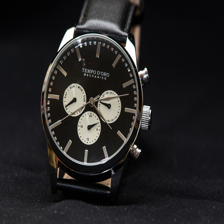

In [4]:
from PIL import Image
from urllib import request
from io import BytesIO
url = "https://github.com/ironmanciti/MachineLearningBasic/blob/master/datasets/TransferLearningData/watch.jpg?raw=true"
res = request.urlopen(url).read()
Sample_Image = Image.open(BytesIO(res)).resize((224, 224))

Sample_Image

In [5]:
x = tf.keras.applications.mobilenet.preprocess_input(np.array(Sample_Image))
x.shape

(224, 224, 3)

In [6]:
predicted_class = Trained_Mobilenet.predict(np.expand_dims(x, axis = 0))

In [7]:
decode_predictions(predicted_class[:, 1:])  # 첫번째 label은 background

49152/35363 [=========================================] - 0s 0us/step


[[('n04328186', 'stopwatch', 9.720387),
  ('n02708093', 'analog_clock', 8.041001),
  ('n03706229', 'magnetic_compass', 6.8818045),
  ('n04548280', 'wall_clock', 6.6048098),
  ('n03075370', 'combination_lock', 4.9255257)]]

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


In [9]:
print(imagenet_labels[:10])

['background' 'tench' 'goldfish' 'great white shark' 'tiger shark'
 'hammerhead' 'electric ray' 'stingray' 'cock' 'hen']


Text(0.5, 1.0, 'Predicted Class is: Stopwatch')

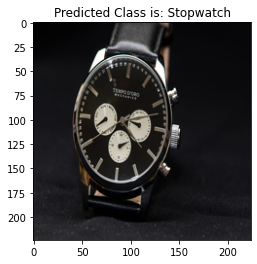

In [10]:
plt.imshow(Sample_Image)
predicted_class = imagenet_labels[np.argmax(predicted_class)]
plt.title("Predicted Class is: " + predicted_class.title())

### 특정 domain 의 Batch Image 에 대한 MobileNet 평가 - No Fine Tuning 

### MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것 예상

In [11]:
# flowers dataset
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
    untar=True)

228827136/228813984 [==============================] - 10s 0us/step


In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

flowers_data = image_generator.flow_from_directory(flowers_data_path, 
                    target_size=(224, 224), batch_size = 64, shuffle = True)

Found 3670 images belonging to 5 classes.


- flower data 는 5 개의 class 로 구성

In [13]:
input_batch, label_batch = next(flowers_data)

print("Image batch shape: ", input_batch.shape)
print("Label batch shape: ", label_batch.shape)
print("Label class 수: ", flowers_data.num_classes)
print("Class Index : ", flowers_data.class_indices)

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [14]:
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 10 개 image 시각화

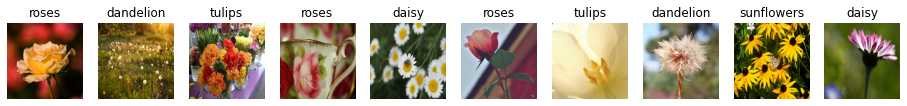

In [15]:
plt.figure(figsize=(16, 8))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

- 임의의 꽃 image 1 개를 선택하여 prediction 비교

In [16]:
prediction = Trained_Mobilenet.predict(input_batch[2:3])
prediction.shape

(1, 1001)

In [17]:
decode_predictions(prediction[:, 1:])  

[[('n03983396', 'pop_bottle', 7.6587367),
  ('n04557648', 'water_bottle', 6.537833),
  ('n03388043', 'fountain', 6.3933873),
  ('n02823428', 'beer_bottle', 5.990986),
  ('n04332243', 'strainer', 5.6820955)]]

### 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain 

### Fine Tuning 을 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [18]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))

In [19]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1280)


- MobileNet 의 pre-trained weight 는 update 않음  

- Top layer 에 Dense layer 추가

In [20]:
extractor_layer.trainable = False

### Model을 두 부분으로 구성:
-    (1)  MobileNet Feature Extractor 
-   (2)  출력 부분에 Dense Network (classifier) 추가 

In [21]:
model = tf.keras.Sequential([
  extractor_layer,
  tf.keras.layers.Dense(flowers_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확한지 training 전에 사전 check

In [23]:
predictions = model(input_batch)

In [24]:
predictions.shape

TensorShape([64, 5])

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 15s 207ms/step - loss: 0.9644 - accuracy: 0.6460
Epoch 2/30
58/58 [==============================] - 12s 203ms/step - loss: 0.4906 - accuracy: 0.8346
Epoch 3/30
58/58 [==============================] - 12s 201ms/step - loss: 0.4034 - accuracy: 0.8643
Epoch 4/30
58/58 [==============================] - 12s 202ms/step - loss: 0.3469 - accuracy: 0.8842
Epoch 5/30
58/58 [==============================] - 12s 203ms/step - loss: 0.3115 - accuracy: 0.9014
Epoch 6/30
58/58 [==============================] - 12s 202ms/step - loss: 0.2817 - accuracy: 0.9106
Epoch 7/30
58/58 [==============================] - 12s 204ms/step - loss: 0.2581 - accuracy: 0.9202
Epoch 8/30
58/58 [==============================] - 12s 204ms/step - loss: 0.2407 - accuracy: 0.9251
Epoch 9/30
58/58 [==============================] - 12s 202ms/step - loss: 0.2208 - accuracy: 0.9319
Epoch 10/30
58/58 [==============================] - 12s 201ms/step - loss: 0.2128 - accura

### Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

In [27]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

array([3, 2, 1, 4, 2, 0, 2, 4, 1, 3, 0, 1, 0, 3, 1, 1, 0, 4, 2, 3, 4, 3,
       1, 2, 0, 4, 0, 4, 4, 4, 3, 3, 4, 0, 0, 3, 3, 0, 1, 0, 4, 0, 3, 2,
       2, 1, 1, 0, 0, 3, 1, 3, 4, 1, 1, 3, 4, 0, 1, 0, 4, 1, 4, 2])

In [28]:
y_true = np.argmax(label_batch, axis=-1)
y_true

array([3, 2, 1, 4, 2, 0, 2, 4, 1, 3, 0, 1, 0, 3, 1, 1, 0, 4, 2, 3, 4, 3,
       1, 2, 0, 4, 0, 2, 4, 4, 3, 3, 4, 0, 0, 3, 3, 0, 1, 0, 4, 0, 3, 2,
       2, 1, 1, 0, 0, 3, 1, 3, 4, 1, 1, 3, 4, 0, 1, 0, 4, 1, 4, 2])

In [29]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'98.44 %'

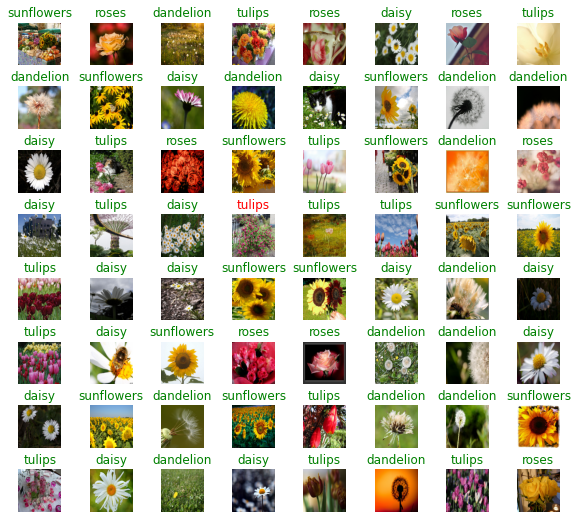

In [30]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
    plt.subplot(8, 8, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    plt.imshow(img)
    color = "green" if y_pred[i] == y_true[i] else "red"
    plt.title(class_names[y_pred[i]], color=color)
    plt.axis('off')
